No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Grid on
Grid on
Grid on
Grid on


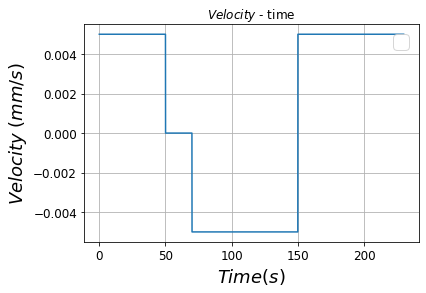

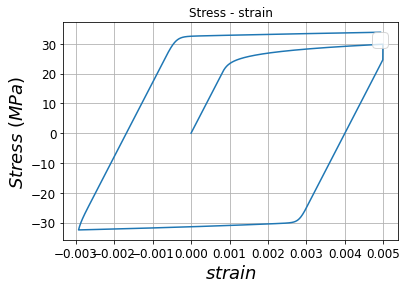

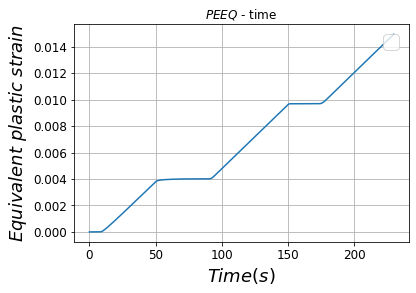

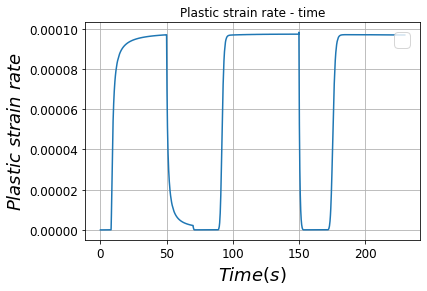

In [1]:
import math       
from pylab import *
import subprocess                 # For issuing commands to the OS.
import os
import sys  
import matplotlib.pyplot as plt                      # For determining the Python version.
import matplotlib.font_manager as font_manager
import pylab
import numpy as np
#
# 
GridOnOff=1 # 0 if you want no grid, 1 if you want the grid to be active
E = 25.e6
L0 = Lt = 50
v = 5.e-3
velocity_temp = 0
eps_total = eps_elastic_t = eps_elastic = 0
eps_point_total = 0
eps_plastic = eps_plastic_t = eps_point_plastic = 0
sigma = sigma_t = 0
t = t0 = 0.
tf = 23.e1  #23.e1
dt = 5.e-3
N = int((tf-t0)/dt) + 1
#
times = np.linspace(t0, tf, N, endpoint = True)
#
m = 0.2
n = 0.25
K = 252.e3/(3**((m+1)/2))
sigma_0 = 20.e3
#
error_evp = 10e-6
eps_small = 10e-18
eps_point_small = 10e-15
eps_plastic_test = eps_point_plastic_test = eps_point_plastic_delt = 0
#
Lt = L0
sigmas = []
eps = []
eps_plastics = []
eps_point_plastics = []
Velocity = []
# 
def get_sigma(sigma_0, K, n, m, eps_point_plastic_test, eps_plastic_test):
    return sigma_0 + K*3**((m+1)/2)*eps_point_plastic_test**m*eps_plastic_test**n
#
def get_f(eps_point_plastic_test, inputs):
    sigma_0 = inputs['sigma_0']
    K = inputs['K']
    n = inputs['n']
    m = inputs['m']
    dt = inputs['dt']
    E = inputs['E']
    sigma_t = inputs['sigma_t']
    eps_plastic_test = inputs['eps_plastic_t'] + eps_point_plastic_test * dt
    eps_point = inputs['eps_point']
    W_TP = sigma_t+E*dt*(eps_point-eps_point_plastic_test)-get_sigma(sigma_0, K, n, m, eps_point_plastic_test, eps_plastic_test)
    return W_TP
    #
def get_Kevp(eps_point_plastic_test, inputs):
    K = inputs['K']
    n = inputs['n']
    m = inputs['m']
    dt = inputs['dt']
    E = inputs['E']
    eps_plastic_test = inputs['eps_plastic_t'] + eps_point_plastic_test * dt
    W_TP = -E*dt-(K*3**((m+1)/2))*(eps_point_plastic_test**m*eps_plastic_test**(n-1)*n*dt + eps_plastic_test**n*eps_point_plastic_test**(m-1)*m)
    return W_TP
#
j = 0     
for t in times:
    eps_point_total = v / Lt
    velocity_temp = v
    if t > 50. and t <= 70.:
        eps_point_total = 0.
        velocity_temp = 0
    elif t > 70. and t <= 150.: 
        eps_point_total = -v / Lt
        velocity_temp = -v
    elif t > 150.: 
        eps_point_total = v / Lt
        velocity_temp = v        
    eps_point_plastic = 0
    yielding = get_f(eps_point_plastic, {'sigma_0': sigma_0, 'K': K, 'n': n, 'm': m, 'dt': dt, 'E': E,
                                         'eps_plastic_t': eps_plastic_t,
                                         'eps_point': eps_point_total, 'sigma_t': abs(sigma_t)})

# #Newton - Raphson start                                    
#     if yielding > 0.:
#         eps_point_plastic_test = 10**-10
#         while yielding > error_evp:
#             Kevp=get_Kevp(eps_point_plastic_test,{'sigma_0': sigma_0, 'K': K, 'n': n, 'm': m, 'dt': dt, 'E': E,
#                                                  'eps_plastic_t': eps_plastic_t,
#                                                  'eps_point': eps_point_total, 'sigma_t': abs(sigma_t)})
#             eps_point_plastic_test -= yielding/Kevp
#             yielding = get_f(eps_point_plastic_test, {'sigma_0': sigma_0, 'K': K, 'n': n, 'm': m, 'dt': dt, 'E': E,
#                                                  'eps_plastic_t': eps_plastic_t,
#                                                  'eps_point': eps_point_total, 'sigma_t': abs(sigma_t)})

#         eps_point_plastic = eps_point_plastic_test
# #Newton - Raphson finish

#Bisection start
    if yielding > 0.:
        eps_point_plastic_test = 0        
        x1 = abs(eps_point_total)+10**-4
        x2 = eps_point_plastic_test
        x3 = (x1+x2)/2
        inputs = {'sigma_0': sigma_0, 'K': K, 'n': n, 'm': m, 'dt': dt, 'E': E,
                    'eps_plastic_t': eps_plastic_t,
                    'eps_point': eps_point_total, 'sigma_t': abs(sigma_t)}
        f1 = get_f(x1, inputs)
        f2 = get_f(x2, inputs)
        f3 = get_f(x3, inputs)

        while (f1*f2 > 0):
             x1 -= 10**-5

        while (abs(x3-x1) > error_evp/1000):
                f3 =  get_f(x3, inputs)   
                if f3 > 0:
                    x2 = x3
                else:
                    x1 = x3
                x3 = (x1+x2)/2

        eps_point_plastic = x3
# Bisection finish


    eps_elastic_t = eps_elastic
    if sigma_t < 0:
        eps_elastic += (eps_point_total + eps_point_plastic)*dt
    elif sigma_t >= 0:
        eps_elastic += (eps_point_total - eps_point_plastic)*dt
    sigma_t = sigma
    if sigma_t < 0:
        sigma += E * (eps_point_total + eps_point_plastic)*dt
    elif sigma_t >= 0:
        sigma += E * (eps_point_total - eps_point_plastic)*dt
#    sigma += E * (eps_point_total - eps_point_plastic)*dt
    eps_plastic += eps_point_plastic*dt
    eps_plastic_t = eps_plastic
    eps_total += eps_point_total*dt
    Lt += v*dt
#
#
    sigmas.append(sigma/1000)
    eps.append(eps_total)
    eps_plastics.append(eps_plastic)
    eps_point_plastics.append(eps_point_plastic)
    Velocity.append(velocity_temp)
#
plt.figure()
plt.plot(times, Velocity)
title("$Velocity$ - time")
xlabel(r'$Time$($s$)',fontsize=18)
ylabel(r'$Velocity$ ($mm/s$)',fontsize=18)
xticks(size=12)
yticks(size=12)
plt.legend(loc='upper right',prop=font_manager.FontProperties(size=20))
if(GridOnOff==1):
	print ('Grid on')
	grid('on')

#
plt.figure()
plt.plot(eps, sigmas)
title('Stress - strain')
xlabel(r'$strain$',fontsize=18)
ylabel(r'$Stress$ ($MPa$)',fontsize=18)
xticks(size=12)
yticks(size=12)
plt.legend(loc='upper right',prop=font_manager.FontProperties(size=20))
if(GridOnOff==1):
	print ('Grid on')
	grid('on')


# 

plt.figure()
plt.plot(times, eps_plastics)
title("$PEEQ$ - time")
xlabel(r'$Time$($s$)',fontsize=18)
ylabel(r'$Equivalent \ plastic \ strain$',fontsize=18)
xticks(size=12)
yticks(size=12)
plt.legend(loc='upper right',prop=font_manager.FontProperties(size=20))
if(GridOnOff==1):
	print ('Grid on')
	grid('on')


# 

plt.figure()
plt.plot(times, eps_point_plastics)
title('Plastic strain rate - time')
xlabel(r'$Time$($s$)',fontsize=18)
ylabel(r'$Plastic \ strain \ rate$',fontsize=18)
xticks(size=12)
yticks(size=12)
plt.legend(loc='upper right',prop=font_manager.FontProperties(size=20))
if(GridOnOff==1):
	print ('Grid on')
	grid('on')

plt.show()

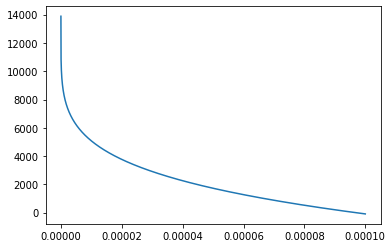

In [2]:
x=np.arange(0,10**-4,10**-8)
y=get_f(x, {'sigma_0': sigma_0, 'K': K, 'n': n, 'm': m, 'dt': dt, 'E': E,
                                         'eps_plastic_t': eps_plastic_t,
                                         'eps_point': eps_point_total, 'sigma_t': sigma_t})
plt.plot(x,y)

In [3]:
yielding= get_f(0, {'sigma_0': sigma_0, 'K': K, 'n': n, 'm': m, 'dt': dt, 'E': E,
                                         'eps_plastic_t': eps_plastic_t,
                                         'eps_point': eps_point_total, 'sigma_t': sigma_t})
yielding

13886.504692174916

In [4]:
sigma_t

33874.28572834306